In [25]:
options(stringsAsFactors=F)
options(max.print=1000)
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(ggsci))
suppressPackageStartupMessages(library(ggrepel))
suppressPackageStartupMessages(library(gridExtra))
suppressPackageStartupMessages(library(RColorBrewer))
suppressPackageStartupMessages(library(circlize))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(corrplot))
suppressPackageStartupMessages(library(igraph))
suppressPackageStartupMessages(library(cowplot))
suppressPackageStartupMessages(library(ggsignif))
suppressPackageStartupMessages(library(ggpubr))
suppressPackageStartupMessages(library(tidyverse))
suppressPackageStartupMessages(library(ComplexHeatmap))
options(bitmapType = 'cairo', device = 'png')

setwd('/psycl/g/mpsziller/lucia/CAD_UKBB/eQTL_PROJECT')
fold_notebook <- '/psycl/g/mpsziller/lucia/castom_cad_scz/jupyter_notebook/'
fold_cl <- "OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/cluster_specific_PALAS/"
file_cl <- "OUTPUT_GTEx/predict_CAD/Liver/200kb/CAD_GWAS_bin5e-2/UKBB/devgeno0.01_testdevgeno0/CAD_HARD_clustering/update_corrPCs/tscore_corrPCs_zscaled_clusterCases_PGmethod_HKmetric.RData"
fold <- "OUTPUT_GTEx/predict_CAD/AllTissues/200kb/CAD_GWAS_bin5e-2/UKBB/"
outFold <- sprintf('%sCAD_clustering/', fold_notebook)

tscore_CAD <- read.table(sprintf('%stscore_pval_CAD_HARD_covCorr.txt', fold), header=T, sep = "\t", stringsAsFactors = F)
pathR_CAD <- read.delim(sprintf('%spath_Reactome_pval_CAD_HARD_covCorr_filt.txt', fold), header=T, sep = "\t", stringsAsFactors = F)
pathGO_CAD <- read.delim(sprintf('%spath_GO_pval_CAD_HARD_covCorr_filt.txt', fold), header=T, sep = "\t", stringsAsFactors = F)
pathWiki_CAD <- read.delim(sprintf('%spath_WikiPath2019Human_pval_CAD_HARD_covCorr_filt.txt', fold), header=T, sep = "\t", stringsAsFactors = F)

tscore_CAD <- tscore_CAD %>% 
    dplyr::mutate(feat_tissue = paste0(ensembl_gene_id, "_", tissue))

tscore_sign <- tscore_CAD %>% 
    dplyr::filter(CAD_HARD_BHcorr < 0.05)

colnames_path <- intersect(colnames(pathWiki_CAD), 
                           intersect(colnames(pathR_CAD), colnames(pathGO_CAD)))

pathR_CAD <- pathR_CAD %>% 
    dplyr::select(all_of(colnames_path)) %>%
    # dplyr::filter(CAD_HARD_BHcorr < 0.05) %>%
    dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
    dplyr::mutate(type = "Reactome")

pathGO_CAD <- pathGO_CAD %>% 
    dplyr::select(all_of(colnames_path)) %>%
    # dplyr::filter(CAD_HARD_BHcorr < 0.05) %>%
    dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
    dplyr::mutate(type = "GO")

pathWiki_CAD <- pathWiki_CAD %>% 
    dplyr::select(all_of(colnames_path)) %>%
    # dplyr::filter(CAD_HARD_BHcorr < 0.05) %>%
    dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
    dplyr::mutate(type = "WikiPathways")

path_CAD <- bind_rows(pathR_CAD, pathGO_CAD, pathWiki_CAD) %>%
    dplyr::mutate(full_id = paste(feat_tissue, type, sep = "_"))

path_sign <- path_CAD %>%
    dplyr::filter(CAD_HARD_BHcorr < 0.05)

cl <- get(load(file_cl))

n_gr <- length(unique(cl$cl_best$gr))
tscore_gr <- list()
pathR_gr <- list()
pathGO_gr <- list()
pathWiki_gr <- list()
path_gr <- list()

tscore_gr_CADsign <- list()
path_gr_CADsign <- list()

for(i in 1:n_gr){
    tscore_gr[[i]] <- read.table(sprintf('%stscore_pval_ClusterCasesVSControls_gr%i.txt', fold_cl, i), 
                                 header=T, sep = "\t", stringsAsFactors = F) 
    tscore_gr[[i]] <- tscore_gr[[i]] %>% 
        dplyr::mutate(feat_tissue = paste0(ensembl_gene_id, "_", tissue))

    tscore_gr_CADsign[[i]] <- tscore_gr[[i]][match(tscore_sign$feat_tissue, tscore_gr[[i]]$feat_tissue),]

    pathR_gr[[i]] <- read.delim(sprintf('%spath_Reactome_pval_ClusterCasesVSControls_gr%i_filt.txt', fold_cl, i), 
                                header=T, sep = "\t", stringsAsFactors = F)
    pathGO_gr[[i]] <- read.delim(sprintf('%spath_GO_pval_ClusterCasesVSControls_gr%i_filt.txt', fold_cl, i), 
                                header=T, sep = "\t", stringsAsFactors = F)
    pathWiki_gr[[i]] <- read.delim(sprintf('%spath_WikiPath2019Human_pval_ClusterCasesVSControls_gr%i_filt.txt', fold_cl, i), 
                                   header=T, sep = "\t", stringsAsFactors = F)

    colnames_path <- intersect(colnames(pathWiki_gr[[i]]), 
                               intersect(colnames(pathR_gr[[i]]), colnames(pathGO_gr[[i]])))

    pathR_gr[[i]] <- pathR_gr[[i]] %>% 
        dplyr::select(all_of(colnames_path)) %>%
        dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
        # dplyr::filter(feat_tissue %in% pathR_CAD_sign$feat_tissue) %>%
        dplyr::mutate(type = "Reactome")

    pathGO_gr[[i]] <- pathGO_gr[[i]] %>% 
        dplyr::select(all_of(colnames_path)) %>%
        dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
        # dplyr::filter(feat_tissue %in% pathGO_CAD_sign$feat_tissue) %>%
        dplyr::mutate(type = "GO")

    pathWiki_gr[[i]] <- pathWiki_gr[[i]] %>%
        dplyr::select(all_of(colnames_path)) %>%
        dplyr::mutate(feat_tissue = paste0(path, "_", tissue)) %>%
        # dplyr::filter(feat_tissue %in% pathWiki_CAD_sign$feat_tissue) %>%
        dplyr::mutate(type = "WikiPathways")
    
    path_gr[[i]] <- bind_rows(
        pathR_gr[[i]], pathGO_gr[[i]], pathWiki_gr[[i]]) %>%
        dplyr::mutate(full_id = paste(feat_tissue, type, sep = "_"))
    
    path_gr_CADsign[[i]] <- path_gr[[i]][match(path_sign$full_id, path_gr[[i]]$full_id),]
    
}

In [26]:
options(repr.plot.width = 5, repr.plot.height = 5, repr.plot.res = 200)

sapply(path_gr, function(x) cor(path_CAD[, 12], x[, 12]))  
sapply(path_gr_CADsign, function(x) cor(path_sign[, 12], x[, 12]))  
dim(path_CAD)
dim(path_sign)

sapply(tscore_gr, function(x) cor(tscore_CAD[, 7], x[, 7]))  
sapply(tscore_gr_CADsign, function(x) cor(tscore_sign[, 7], x[, 7]))  
dim(tscore_CAD)
dim(tscore_sign)


[1] 0.29724185 0.39178213 0.38183926 0.03252527 0.05272753

[1] -0.05649286  0.55297230  0.48996004  0.25856412 -0.19704575

[1] 36949    22

[1] 567  22

[1] 0.44686276 0.39312784 0.19397951 0.09234402 0.20205441

[1]  0.11256946  0.53779119 -0.06119203 -0.02814251  0.01369028

[1] 36424    13

[1] 383  13

Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”


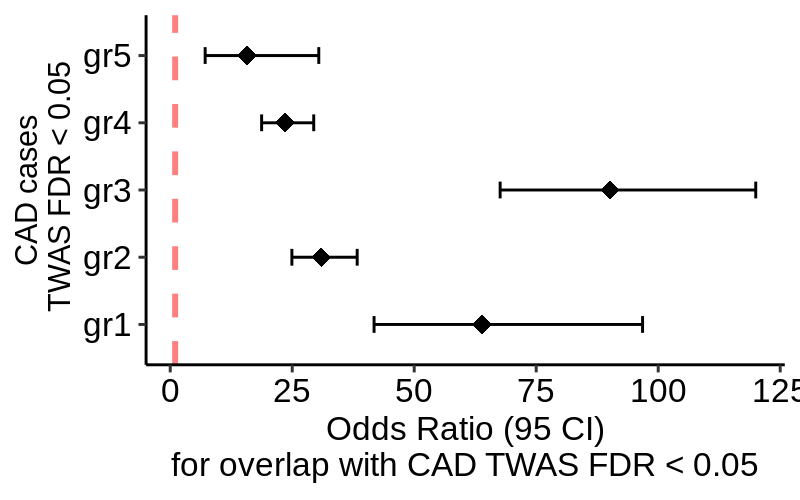

estimate,lower,upper,gr,pvalue
<dbl>,<dbl>,<dbl>,<chr>,<dbl>
38.410291,30.133946,48.810710,gr1,2.827135e-121
7.355922,6.190476,8.724613,gr2,5.406736e-93
14.286874,11.014715,18.320051,gr3,1.101993e-57
4.647381,3.854306,5.580189,gr4,2.201493e-47
15.798143,11.330756,21.616723,gr5,7.537188e-38


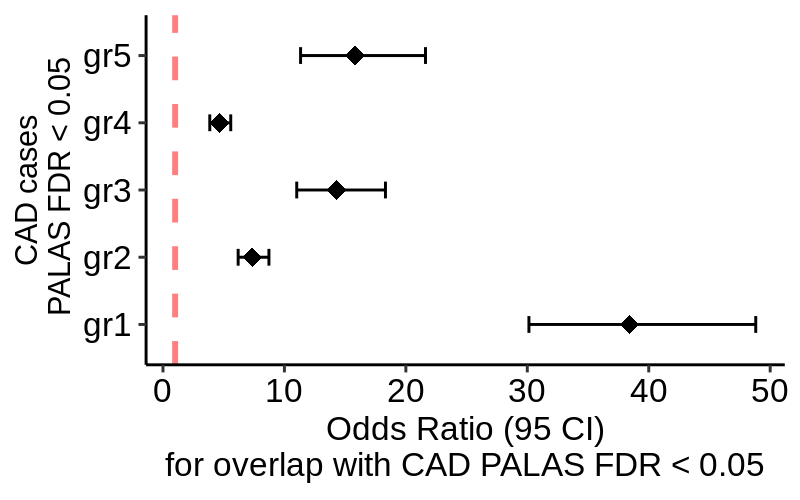

In [138]:
library(epitools)
options(repr.plot.width = 4, repr.plot.height = 2.5, repr.plot.res = 200)

compute_enrichment <- function(res_CAD, res_gr, pval_corr_thr, id_pval_corr, type_data, outFold){
    
    df <- list()
    for(i in 1:length(res_gr)){
        data <- table(res_CAD[, id_pval_corr] <= pval_corr_thr, res_gr[[i]][,id_pval_corr] <= pval_corr_thr)
        dimnames(data) <- list('Group' = c("FDR > 0.05", "FDR < 0.05"), 'CAD' = c("FDR > 0.05", "FDR < 0.05"))
        df[[i]] <- as.data.frame(t(oddsratio(data)$measure["FDR < 0.05",])) %>% mutate(gr = i, pvalue = oddsratio(data)$p.value["FDR < 0.05", 2])
    }
    df <- bind_rows(df) %>%
        mutate(gr = paste0("gr", gr))
    
    pl <- ggplot(df, aes(y = gr, x = estimate)) +
    geom_point(shape = 18, size = 3) +  
    geom_errorbarh(aes(xmin = lower, xmax = upper), height = 0.25) +
    geom_vline(xintercept = 1, color = "red", linetype = "dashed", cex = 1, alpha = 0.5) +
    # scale_y_continuous(name = "", breaks=1:4, labels = dat$, trans = "reverse") +
    xlab(sprintf("Odds Ratio (95 CI)\nfor overlap with CAD %s FDR < 0.05", type_data)) + 
    ylab(sprintf("CAD cases\n %s FDR < 0.05", type_data)) + 
    theme_bw() +
    theme(panel.border = element_blank(),
        panel.background = element_blank(),
        panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), 
        axis.line = element_line(colour = "black"),
        axis.text.y = element_text(size = 12, colour = "black"),
        axis.text.x.bottom = element_text(size = 12, colour = "black"),
        axis.title.x = element_text(size = 12, colour = "black"))

    print(pl)
    ggsave(sprintf("%s%s_enrichment_CAD_and_group_FDR005.pdf", outFold, type_data), pl, width = 4, height = 2.5, dpi = 300)
    #df <- data.frame(OR = rep(NA, length(res_gr)), pvalue_fisher = rep(NA, length(res_gr)))
    #df$OR <- unname(sapply(res_gr, function(x) 
    #fisher.test(table(x[,id_pval_corr] <= pval_corr_thr, res_CAD[, id_pval_corr] <= pval_corr_thr))$estimate))
    #df$pvalue_fisher <- unname(sapply(res_gr, function(x) 
    #fisher.test(table(x[,id_pval_corr] <= pval_corr_thr, res_CAD[, id_pval_corr] <= pval_corr_thr))$p.value))
    return(df)
}
df_tscore <- compute_enrichment(tscore_CAD, tscore_gr, pval_corr_thr = 0.05, id_pval_corr = 10, type_data = "TWAS", outFold = outFold)
df_path <- compute_enrichment(path_CAD, path_gr, pval_corr_thr = 0.05, id_pval_corr = 15, type_data = "PALAS", outFold = outFold)
df_path

In [28]:
# get unique paths across tissues (best z-stat in CAD), remove those that are discordant across tissues based on z-stat sign
id_zstat <- 12
id_pval <- 13
id_pval_corr <- 15 

path_sign_notuniq <- path_sign %>% 
    dplyr::group_by(path, type) %>%
    dplyr::mutate(n_tissues = n()) %>%
    dplyr::filter(n_tissues > 1) %>%
    dplyr::mutate(path_type = paste0(path, "_", type)) %>%
    dplyr::ungroup()

path_name <- path_sign_notuniq %>% 
    dplyr::pull(path_type) %>%
    unique() 
length(path_name)

keep_path <- data.frame()

for(i in 1:length(path_name)){
    tmp <- path_sign %>% 
    dplyr::mutate(path_type = paste0(path, "_", type)) %>%
    dplyr::filter(path_type == path_name[i])
    
    if(all(sign(tmp[, id_zstat]) == 1) | all(sign(tmp[, id_zstat]) == -1)){
        tmp <- tmp[which.min(tmp[, id_pval]), ]
        keep_path <- rbind(keep_path, tmp)
    }  
}
dim(keep_path)

path_sign_conc <- path_sign %>% 
    dplyr::group_by(path, type) %>%
    dplyr::mutate(n_tissues = n()) %>%
    dplyr::filter(n_tissues == 1) %>%
    dplyr::select(-n_tissues) %>%
    dplyr::ungroup()
dim(path_sign_conc)

path_sign_conc <- bind_rows(
    path_sign_conc, 
    keep_path %>% dplyr::select(-path_type))

dim(path_sign_conc)
dim(path_sign)


[1] 65

[1] 62 23

[1] 399  22

[1] 461  22

[1] 567  22

- 567 significant pathways across GO, Reactome and wiki
- Of those, 399 are only in a tissue.
- 168 are in more than one tissue, 65 are unique
- We filter 65 pathways keeping only those more significant if the Z-stat sign is concordant, if not we discard it. Resulting number is 62 pathways
- The total list includes 461 pathways

In [29]:
# get unique genes across tissues (best z-stat in CAD), remove those that are discordant across tissues based on z-stat sign
id_zstat <- 7
id_pval <- 8
id_pval_corr <- 10 

tscore_sign_notuniq <- tscore_sign %>% 
    dplyr::group_by(ensembl_gene_id) %>%
    dplyr::mutate(n_tissues = n()) %>%
    dplyr::filter(n_tissues > 1) %>%
    dplyr::ungroup()

gene_name <- tscore_sign_notuniq %>% 
    dplyr::pull(ensembl_gene_id) %>%
    unique() 
length(gene_name)

keep_gene <- data.frame()

for(i in 1:length(gene_name)){
    tmp <- tscore_sign %>% 
    dplyr::filter(ensembl_gene_id == gene_name[i])
    
    if(all(sign(tmp[, id_zstat]) == 1) | all(sign(tmp[, id_zstat]) == -1)){
        tmp <- tmp[which.min(tmp[, id_pval]), ]
        keep_gene <- rbind(keep_gene, tmp)
    }  
}
dim(keep_gene)

tscore_sign_conc <- tscore_sign %>% 
    dplyr::group_by(ensembl_gene_id) %>%
    dplyr::mutate(n_tissues = n()) %>%
    dplyr::filter(n_tissues == 1) %>%
    dplyr::select(-n_tissues) %>%
    dplyr::ungroup()
dim(tscore_sign_conc)

tscore_sign_conc <- bind_rows(
    tscore_sign_conc, 
    keep_gene)

dim(tscore_sign_conc)
dim(tscore_sign)

[1] 62

[1] 62 13

[1] 118  13

[1] 180  13

[1] 383  13

- 383 significant genes
- Of those, 118 are only in a tissue.
- 265 are in more than one tissue, 62 are unique
- All of this 62 have the same Z-stat sign in all tissues
- The total list includes 180 tissues

In [31]:
get_short_name <- function(tissue_name){
    tmp <- sapply(strsplit(tissue_name, split = '_')[[1]], function(x) 
        substr(x = x, start = 1, stop = 1))
    out <- paste0(tmp, collapse = '')
    out <- paste0('(', out,')')
    return(out)
}

path_sign_conc <- path_sign_conc %>% 
    dplyr::mutate(short_tissue = sapply(tissue, function(x) get_short_name(x))) %>%
    dplyr::mutate(plot_id = paste(path, short_tissue))

tscore_sign_conc <- tscore_sign_conc %>% 
    dplyr::mutate(short_tissue = sapply(tissue, function(x) get_short_name(x))) %>%
    dplyr::mutate(plot_id = paste(external_gene_name, short_tissue))

path_gr_CADsign_conc <- list()
for(i in 1:n_gr){
    path_gr_CADsign_conc[[i]] <- path_gr_CADsign[[i]][match(path_sign_conc$full_id, path_gr_CADsign[[i]]$full_id),]
}

tscore_gr_CADsign_conc <- list()
for(i in 1:n_gr){
    tscore_gr_CADsign_conc[[i]] <- tscore_gr_CADsign[[i]][match(tscore_sign_conc$feat_tissue, tscore_gr_CADsign[[i]]$feat_tissue),]
}
                       

png 
  2

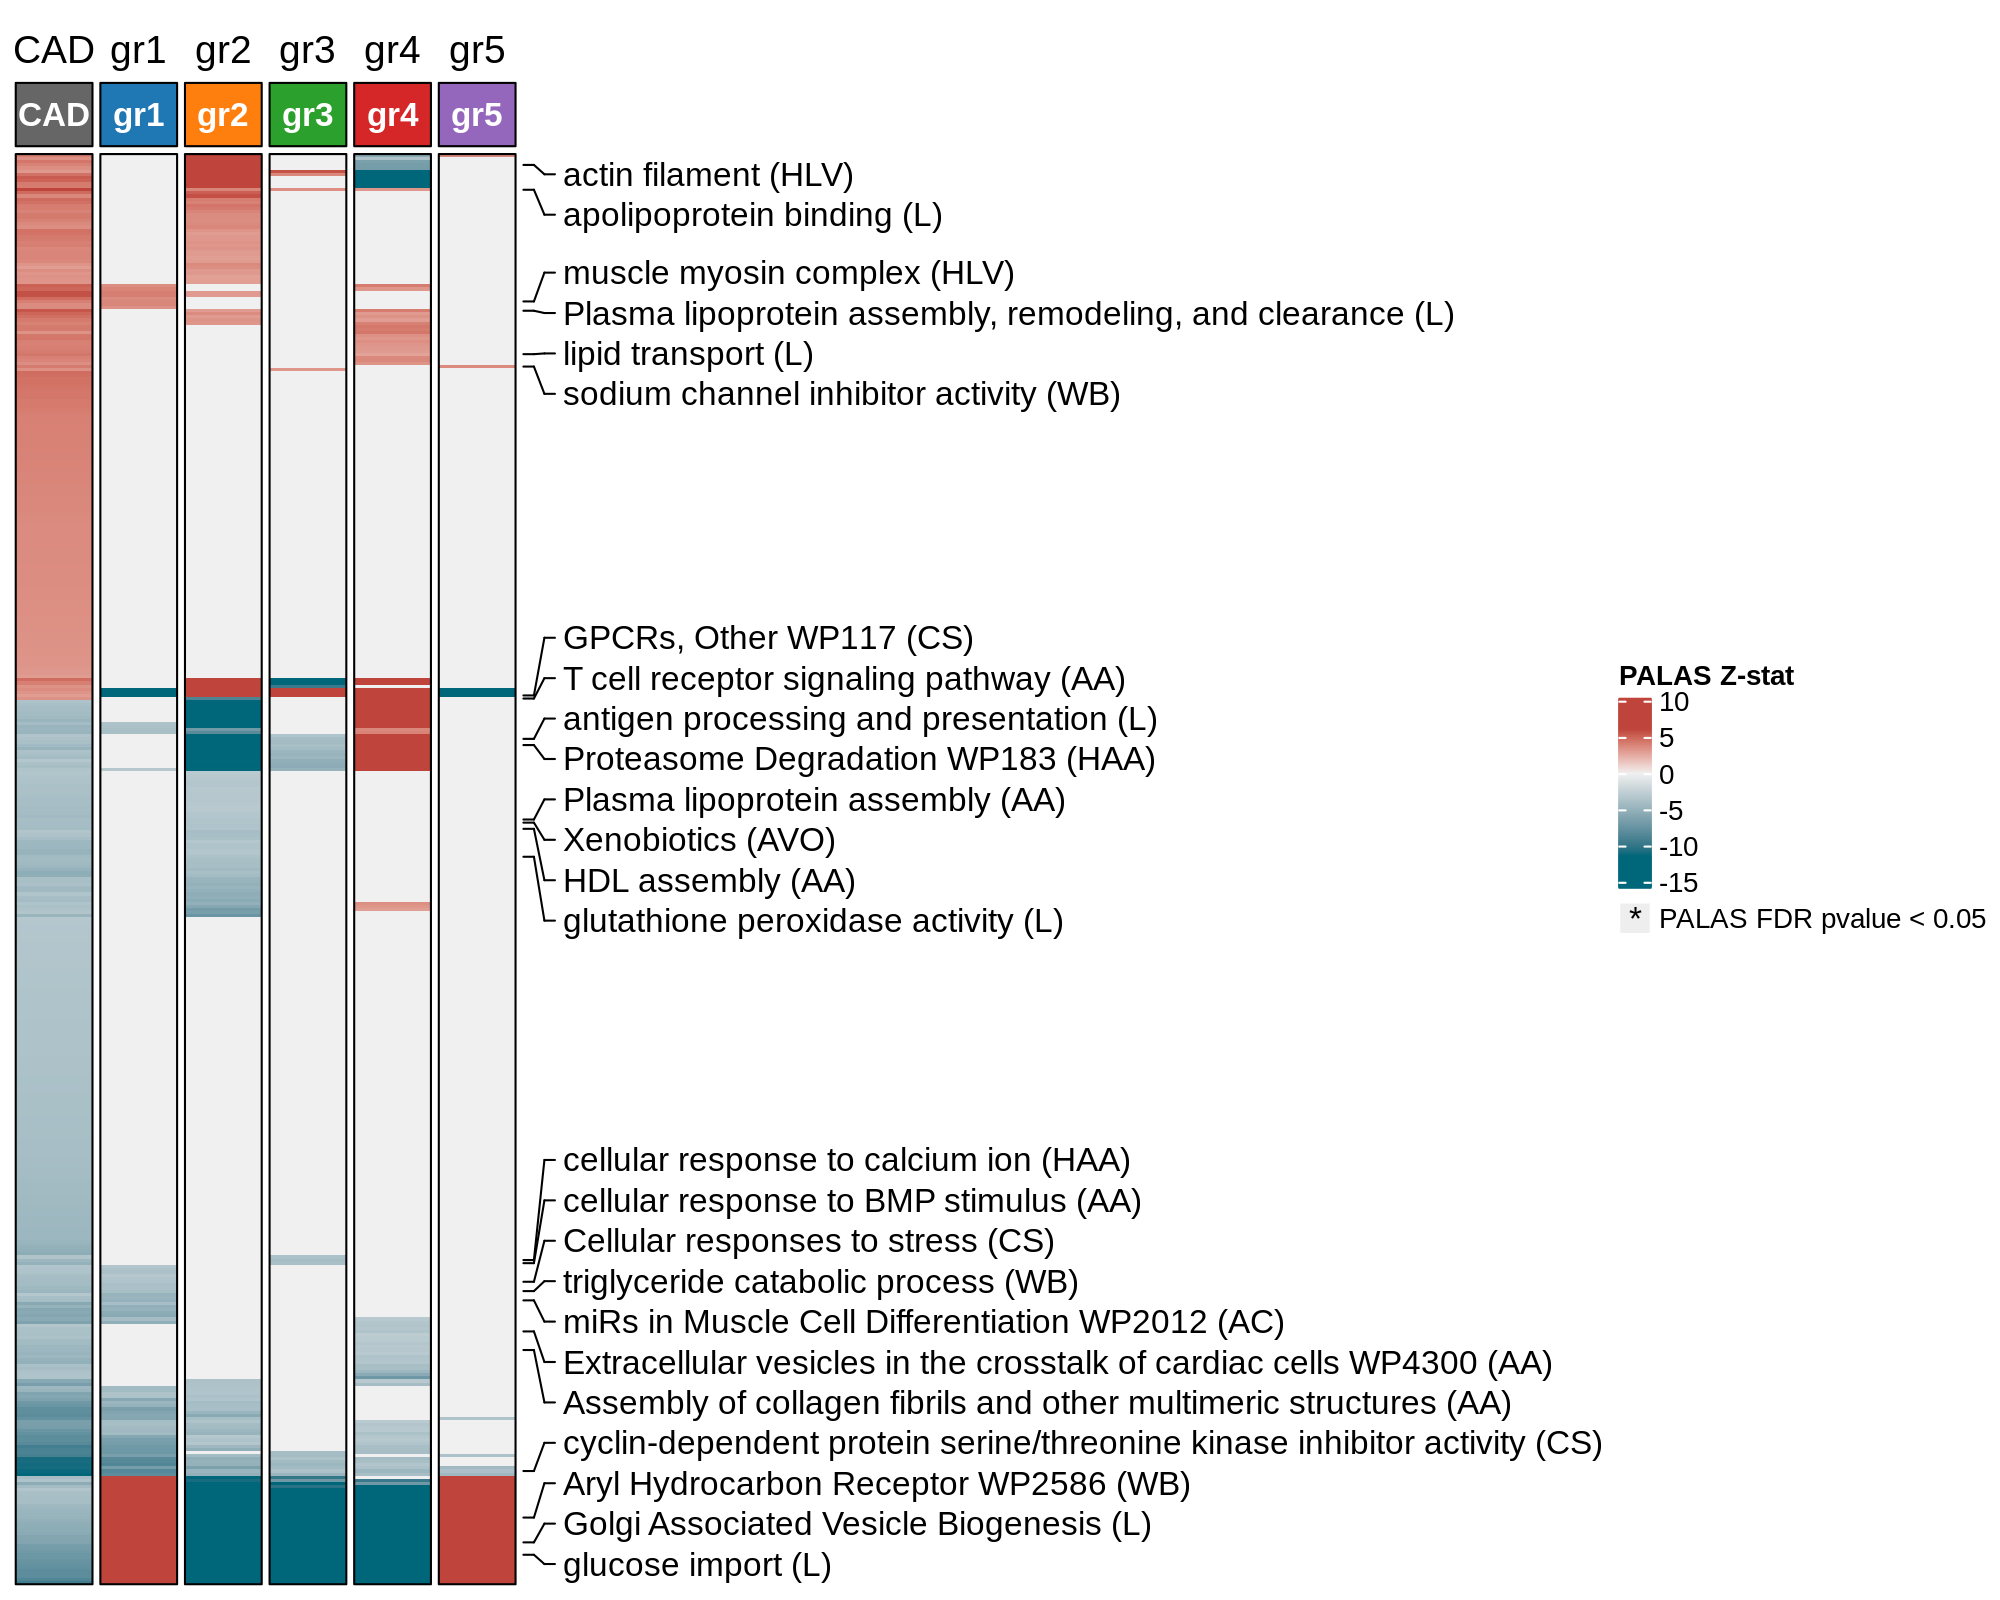

In [59]:
options(repr.plot.width = 10, repr.plot.height = 8, repr.plot.res = 200)

id_zstat <- 12
id_pval <- 13
id_pval_corr <- 15
pval_corr_thr <- 0.05

# path to plot:
list_plot <- c("cyclin-dependent protein serine/threonine kinase inhibitor activity (CS)", 
               "Golgi Associated Vesicle Biogenesis (L)", 
               "glucose import (L)", 
               "Aryl Hydrocarbon Receptor WP2586 (WB)", 
               "GPCRs, Other WP117 (CS)", "triglyceride catabolic process (WB)", 
               "Cellular responses to stress (CS)", 
               "miRs in Muscle Cell Differentiation WP2012 (AC)", 
               "muscle myosin complex (HLV)", "Plasma lipoprotein assembly (AA)", "Xenobiotics (AVO)", "glutathione peroxidase activity (L)", 
               "HDL assembly (AA)", "cellular response to BMP stimulus (AA)", "cellular response to calcium ion (HAA)", 
               "Assembly of collagen fibrils and other multimeric structures (AA)", 
               "lipid transport (L)", "Extracellular vesicles in the crosstalk of cardiac cells WP4300 (AA)",
              "sodium channel inhibitor activity (WB)", "actin filament (HLV)", "Plasma lipoprotein assembly, remodeling, and clearance (L)", 
              "T cell receptor signaling pathway (AA)","Proteasome Degradation WP183 (HAA)", "antigen processing and presentation (L)", 
              "apolipoprotein binding (L)")
id <- which(path_sign_conc$plot_id %in% list_plot)

mat_zstat <- cbind(path_sign_conc[, id_zstat], sapply(path_gr_CADsign_conc, function(x) x[, id_zstat]))
mat_pval <- cbind(path_sign_conc[, id_pval_corr], sapply(path_gr_CADsign_conc, function(x) x[, id_pval_corr]))
rownames(mat_zstat) <- rownames(mat_pval) <- path_sign_conc$plot_id
colnames(mat_zstat) <- colnames(mat_pval) <- c("CAD", paste0("gr", 1:n_gr))

val_min <- min(mat_zstat[,1])
val_max <- max(mat_zstat[,1])
mat_breaks <- seq(val_min, val_max, length.out = 100)
mat_zstat[mat_zstat >= val_max] <- val_max
mat_zstat[mat_zstat <= val_min] <- val_min

feat_pvcorr_pch <- as.matrix(mat_pval)
feat_pvcorr_pch[as.matrix(mat_pval) <= pval_corr_thr] <- '*'
feat_pvcorr_pch[as.matrix(mat_pval) > pval_corr_thr] <- ''
feat_pvcorr_pch[,1] <- ''

estimate_col_fun = colorRamp2(c(min(mat_zstat), 0, max(mat_zstat)), 
                                c("#00677B", "#F0F0F0", "#BF443B"))
lgd_est <- Legend(title = "PALAS Z-stat", col = estimate_col_fun)
lgd_sig = Legend(pch = "*", type = "points", labels = sprintf("PALAS FDR pvalue < %s", as.character(pval_corr_thr)))

mat_colors_gr <- list(cluster = c("grey40", pal_d3(palette = 'category20')(n_gr)))
names(mat_colors_gr$cluster) <- c("CAD", paste0("gr", 1:n_gr))
column_ha <- HeatmapAnnotation(cluster = anno_block(gp = gpar(fill = mat_colors_gr$cluster),
                                                    labels = names(mat_colors_gr$cluster),
                                                    labels_gp = gpar(col = "white", fontsize = 12,  
                                                                     fontface = "bold")))

row_ha_names <- rowAnnotation(foo = anno_mark(at = id, 
                                              labels = path_sign_conc$plot_id[id])) 

tmp_mat <- as.matrix(mat_zstat)
tmp_mat[as.matrix(mat_pval) > pval_corr_thr] <- 0
# save 
write.table(tmp_mat, sprintf('%sheatmap_PALAS_CAD_and_ClusterCases.txt', outFold), 
            sep = "\t", quote = F, row.names = T, col.names = T)

# order
hm_pl <- Heatmap(tmp_mat,
                 top_annotation = column_ha, 
                 right_annotation = row_ha_names, 
                 cluster_rows = TRUE, 
                 cluster_columns = FALSE, 
                 show_column_names = FALSE, 
                 show_row_names = FALSE, 
                 show_row_dend=FALSE, 
                 border = TRUE, 
                 show_heatmap_legend = FALSE,
                 column_split = c("CAD", paste0("gr", 1:n_gr)),
                 col = estimate_col_fun)
                 #cell_fun = function(j, i, x, y, width, height, fill){
                 #          grid.text(sprintf("%s", feat_pvcorr_pch[i, j]), x, y, gp = gpar(fontsize = 8))})

pdf(sprintf('%sheatmap_PALAS_CAD_and_ClusterCases.pdf', outFold), width= 10, height = 8)
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig)) 
dev.off()
draw(hm_pl, annotation_legend_list = list(lgd_est, lgd_sig)) 



FALSE  TRUE 
  208   253 

[1] 461   6

png 
  2

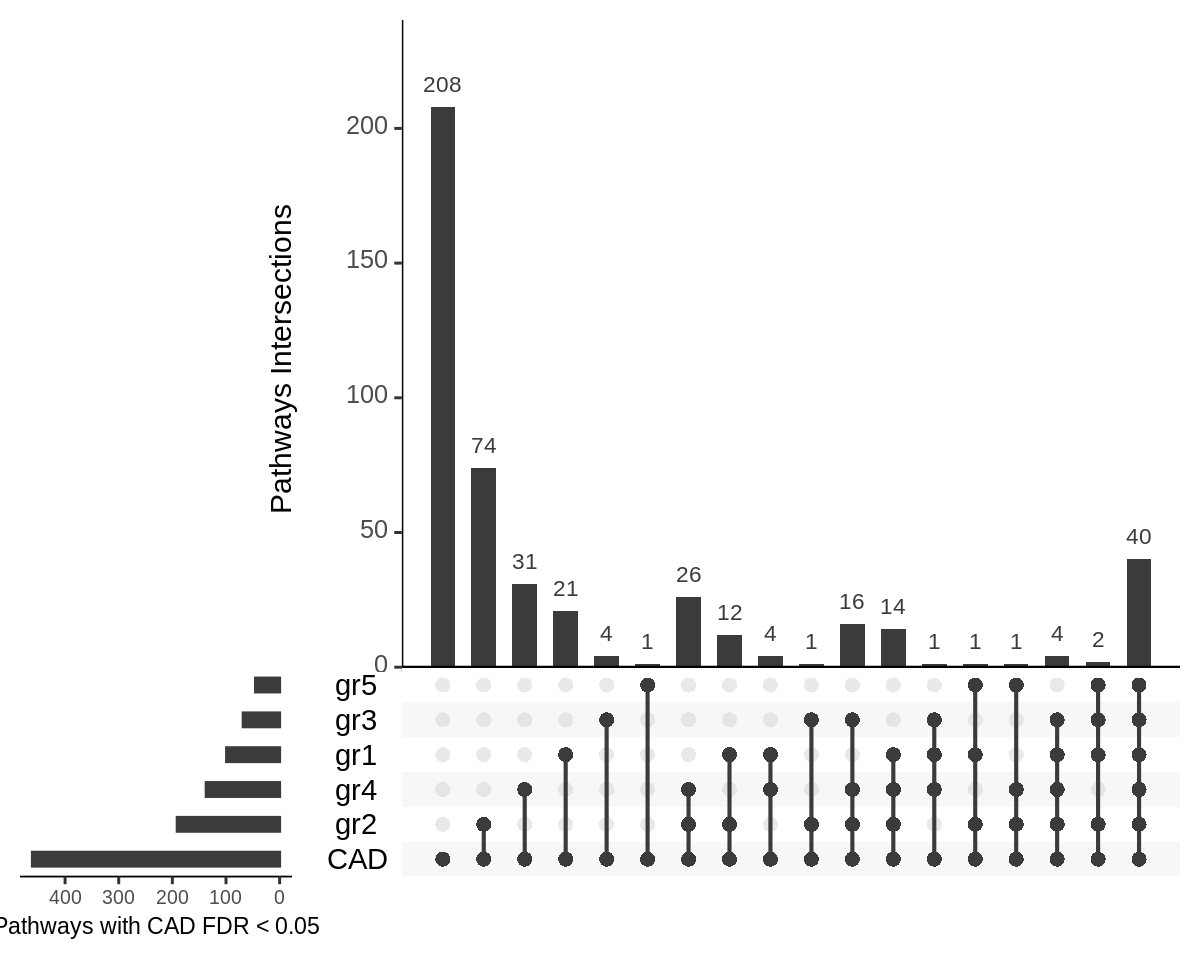

In [137]:
options(repr.plot.width = 6, repr.plot.height = 4.8, repr.plot.res = 200)

# how many in at least one group?
table(rowSums(tmp_mat[,-1] != 0) > 0)
dim(tmp_mat)

# 253 are in at least one group
library(UpSetR)
df <- data.frame(path = rownames(tmp_mat), t(apply(tmp_mat, 1, function(x) as.numeric(x != 0))))
colnames(df)[-1] <- colnames(tmp_mat)

pdf(sprintf('%sUpsetPlot_PALAS_CAD_and_ClusterCases.pdf', outFold), width= 6, height = 4.8)
pl <- upset(df, sets = colnames(tmp_mat), mb.ratio = c(0.7, 0.3),  
      mainbar.y.label = "Pathways Intersections", sets.x.label = "Pathways with CAD FDR < 0.05", 
      text.scale = c(1.3, 1.3, 1, 1, 1.5, 1.3))
dev.off()

upset(df, sets = colnames(tmp_mat), mb.ratio = c(0.7, 0.3),  
      mainbar.y.label = "Pathways Intersections", sets.x.label = "Pathways with CAD FDR < 0.05", 
      text.scale = c(1.3, 1.3, 1, 1, 1.5, 1.3))

In [30]:
id_zstat <- 12
id_pval <- 13
id_pval_corr <- 15 

lapply(path_gr, function(x) table(x[, id_pval_corr] <= pval_corr_thr, path_CAD[, id_pval_corr] <= pval_corr_thr))


sapply(path_gr_CADsign_conc, function(x) sum(x[, id_pval_corr] <= pval_corr_thr))
table(rowSums(sapply(path_gr_CADsign_conc, function(x) x[, id_pval_corr] <= pval_corr_thr)) > 0)
sapply(path_gr_CADsign_conc, function(x) sum(x[, id_pval_corr] <= pval_corr_thr & sign(x[,id_zstat]) == sign(path_sign_conc[,id_zstat])))
table(rowSums(sapply(path_gr_CADsign_conc, function(x) x[, id_pval_corr] <= pval_corr_thr & sign(x[,id_zstat]) == sign(path_sign_conc[,id_zstat]))) > 0)

table(rowSums(sapply(path_gr_CADsign_conc, function(x) x[, id_pval] <= pval_corr_thr)) == n_gr)
id = rowSums(sapply(path_gr_CADsign_conc, function(x) x[, id_pval] <= pval_corr_thr)) == n_gr
# path_sign_conc[id,]
table(rowSums(sapply(path_gr_CADsign_conc, function(x) x[, id_pval] <= pval_corr_thr & sign(x[,id_zstat]) == sign(path_sign_conc[,id_zstat]) )) == n_gr)




[[1]]
       
        FALSE  TRUE
  FALSE 36140   451
  TRUE    242   116

[[2]]
       
        FALSE  TRUE
  FALSE 33272   336
  TRUE   3110   231

[[3]]
       
        FALSE  TRUE
  FALSE 35962   486
  TRUE    420    81

[[4]]
       
        FALSE  TRUE
  FALSE 33405   401
  TRUE   2977   166

[[5]]
       
        FALSE  TRUE
  FALSE 36165   518
  TRUE    217    49


[1]  99 191  68 137  45


FALSE  TRUE 
  208   253 

[1]  61 190  65 100   7


FALSE  TRUE 
  208   253 


FALSE  TRUE 
  409    52 


FALSE  TRUE 
  450    11 

In [27]:
id_zstat <- 7
id_pval <- 8
id_pval_corr <- 10 
pval_corr_thr <- 0.05

sapply(tscore_gr, function(x) sum(x[, id_pval_corr] <= pval_corr_thr))
a = tscore_gr[[5]][tscore_gr[[5]][, id_pval_corr] <= pval_corr_thr,]
b = tscore_CAD[tscore_CAD[, id_pval_corr] <= pval_corr_thr,]
lapply(tscore_gr, function(x) table(x[, id_pval_corr] <= pval_corr_thr, tscore_CAD[, id_pval_corr] <= pval_corr_thr))

sapply(tscore_gr_CADsign_conc, function(x) sum(x[, id_pval_corr] <= pval_corr_thr))
sapply(tscore_gr_CADsign_conc, function(x) sum(x[, id_pval_corr] <= pval_corr_thr & sign(x[,id_zstat]) == sign(tscore_sign_conc[,id_zstat])))

table(rowSums(sapply(tscore_gr_CADsign_conc, function(x) x[, id_pval] <= pval_corr_thr)) == n_gr)
id = rowSums(sapply(tscore_gr_CADsign_conc, function(x) x[, id_pval] <= pval_corr_thr)) == n_gr
# tscore_sign_conc[id,]
table(rowSums(sapply(tscore_gr_CADsign_conc, function(x) x[, id_pval] <= pval_corr_thr & sign(x[,id_zstat]) == sign(tscore_sign_conc[,id_zstat]) )) == n_gr)
id = rowSums(sapply(tscore_gr_CADsign_conc, function(x) x[, id_pval] <= pval_corr_thr & sign(x[,id_zstat]) == sign(tscore_sign_conc[,id_zstat]) )) == n_gr
tscore_sign_conc[id,]

[1] 100 967 232 862  65

[[1]]
       
        FALSE  TRUE
  FALSE 35979   345
  TRUE     62    38

[[2]]
       
        FALSE  TRUE
  FALSE 35233   224
  TRUE    808   159

[[3]]
       
        FALSE  TRUE
  FALSE 35906   286
  TRUE    135    97

[[4]]
       
        FALSE  TRUE
  FALSE 35305   257
  TRUE    736   126

[[5]]
       
        FALSE  TRUE
  FALSE 35985   374
  TRUE     56     9


[1] 26 54 36 52  8

[1] 20 54 25 37  2


FALSE  TRUE 
  168    12 


FALSE  TRUE 
  175     5 

ensembl_gene_id,external_gene_name,dev_geno,test_dev_geno,CAD_HARD_beta,CAD_HARD_se_beta,CAD_HARD_z_t,CAD_HARD_pval,CAD_HARD_qval,CAD_HARD_BHcorr,tissue,CAD_HARD_BHcorr_overall,feat_tissue,short_tissue,plot_id
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<chr>
ENSG00000147883,CDKN2B,0.07533683,0.0001990896,-0.0003683194,2.486965e-05,-14.809994,1.262515e-49,2.952029e-46,3.378490e-46,Colon_Sigmoid,4.598585e-45,ENSG00000147883_Colon_Sigmoid,(CS),CDKN2B (CS)
ENSG00000272750,RP11-378J18.8,0.05633189,0.0321785254,-0.0001910492,2.524008e-05,-7.569279,3.753000e-14,1.906733e-10,2.098302e-10,Adipose_Subcutaneous,2.028058e-10,ENSG00000272750_Adipose_Subcutaneous,(AS),RP11-378J18.8 (AS)
ENSG00000144426,NBEAL1,0.09543016,0.0888637101,-0.0001808879,2.391315e-05,-7.564368,3.897542e-14,7.455380e-11,9.434002e-11,Artery_Aorta,2.028058e-10,ENSG00000144426_Artery_Aorta,(AA),NBEAL1 (AA)
ENSG00000138439,FAM117B,0.03249481,0.0033771008,-0.0001789556,2.409354e-05,-7.427534,1.106407e-13,8.485570e-11,1.073760e-10,Artery_Aorta,4.039520e-10,ENSG00000138439_Artery_Aorta,(AA),FAM117B (AA)
ENSG00000186063,AIDA,0.09274668,0.0271636358,0.0001445294,2.538520e-05,5.693449,1.244984e-08,9.703458e-06,1.110526e-05,Colon_Sigmoid,1.511577e-05,ENSG00000186063_Colon_Sigmoid,(CS),AIDA (CS)
